In [ ]:
#| hide
from hybridpredictmaize22.GEMdataset import *
from hybridpredictmaize22.GEMlearn import *

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler
from pathlib import Path

# hybridpredictmaize22

> GxExM yield prediction

Repo for analysis of GEM prediction for maize yield

## Install

```sh
pip install hybridpredictmaize22
```

## How to use

A demo of the library specifically for this dataset

Generate random data that is the same form as the actual dataset

In [ ]:
import random
#generate random SNP matrix
gene_dosages = [0, .5, 1]
years = [2018,2019]
snp_length = 100
number_hybrids = 20


number_environments = 10
env_col = []
for i,y in zip(np.arange(number_environments),[random.choice(years) for _ in range(number_environments)]):
    env_col.append(f'{i}_{y}')

snp_matrix = (np.arange(number_hybrids),np.array([[random.choice(gene_dosages) for x in range(snp_length)] for _ in range(number_hybrids)]))

#generate random yield data
random_yields = [random.uniform(-1,1) for _ in range(100)]
random_hybrids = [random.choice(range(number_hybrids)) for _ in range(100)]
random_environments = [random.choice((env_col)) for _ in range(100)]

In [ ]:
yield_data = pd.DataFrame({"Hybrid":random_hybrids, "Yield_Mg_ha":random_yields, 'Env':random_environments})
yield_data.head()

,Hybrid,Yield_Mg_ha,Env
0,14,0.219848,5_2019
1,16,0.538425,8_2019
2,16,0.921895,2_2019
3,6,-0.993358,4_2019
4,6,-0.722921,2_2019


In [ ]:
Weather_Table = np.random.random((50,number_environments))
weather_table = {}
for c,i in enumerate(Weather_Table):
    weather_table[c] = i
    
weather_data = pd.DataFrame(weather_table)
weather_data.insert(0,'Env',env_col)
weather_data.insert(1,'Year',[x.split('_')[1] for x in env_col])

(weather_data)

,Env,Year,0,1,2,3,4,5,6,7,...,40,41,42,43,44,45,46,47,48,49
0,0_2018,2018,0.090504,0.190406,0.487055,0.856964,0.048595,0.782404,0.932119,0.604640,...,0.327276,0.811860,0.250868,0.967916,0.717378,0.041461,0.853717,0.570870,0.865140,0.974558
1,1_2018,2018,0.832647,0.438793,0.434207,0.318412,0.056956,0.369894,0.356342,0.922811,...,0.734138,0.751515,0.169039,0.395011,0.146937,0.102186,0.499660,0.098832,0.473252,0.071471
2,2_2019,2019,0.755381,0.202103,0.209770,0.841516,0.154603,0.789997,0.106939,0.026476,...,0.288460,0.923316,0.272401,0.359577,0.656206,0.450100,0.495506,0.509083,0.514762,0.172253
3,3_2018,2018,0.469916,0.646785,0.881478,0.499406,0.653779,0.493970,0.785830,0.241786,...,0.784110,0.217957,0.069367,0.995609,0.600673,0.493468,0.010605,0.979546,0.746203,0.454766
4,4_2019,2019,0.685245,0.603269,0.552968,0.857774,0.590732,0.553667,0.072938,0.799972,...,0.671518,0.048937,0.626047,0.607124,0.585469,0.794031,0.993070,0.067475,0.373957,0.408206
5,5_2019,2019,0.428437,0.814462,0.940537,0.077722,0.661550,0.317286,0.346178,0.678108,...,0.258266,0.964766,0.418675,0.586637,0.316594,0.534758,0.271571,0.379752,0.765951,0.113872
6,6_2019,2019,0.264825,0.961481,0.166661,0.764215,0.149717,0.434268,0.632117,0.851591,...,0.514611,0.488366,0.019868,0.487827,0.040701,0.615436,0.442033,0.844340,0.171262,0.637241
7,7_2018,2018,0.478966,0.355626,0.429861,0.398623,0.320606,0.090721,0.254338,0.050240,...,0.216189,0.289679,0.782013,0.197285,0.778175,0.133279,0.247789,0.138276,0.451989,0.483286
8,8_2019,2019,0.799479,0.299206,0.077325,0.354348,0.537312,0.794558,0.910754,0.728746,...,0.121775,0.117276,0.719571,0.691089,0.481006,0.108865,0.716467,0.358639,0.693075,0.356856
9,9_2019,2019,0.101469,0.576532,0.148550,0.670102,0.878643,0.931698,0.369360,0.253712,...,0.131750,0.783244,0.476852,0.234867,0.101564,0.791949,0.645135,0.263196,0.353880,0.956912


In [ ]:
yield_data

,Hybrid,Yield_Mg_ha,Env
0,14,0.219848,5_2019
1,16,0.538425,8_2019
2,16,0.921895,2_2019
3,6,-0.993358,4_2019
4,6,-0.722921,2_2019
...,...,...,...
95,7,-0.258061,1_2018
96,8,-0.081160,5_2019
97,16,0.219072,2_2019
98,11,0.660305,0_2018


In [ ]:
#Create a GEM dataset
test_split = 2019
gem = GEM(test_split)
gem.Y = YT(yield_data, test_split)
gem.W = WT(weather_data, test_split)
gem.SNP = snp_matrix

In [ ]:
#example of how to unscale a value
gem.Y.scaler.inverse_transform(np.array(1.4).reshape(-1,1))

array([[0.90851887]])

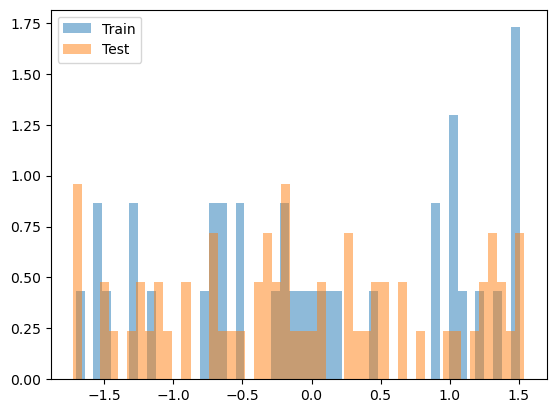

In [ ]:
gem.Y.plot_yields()

In [ ]:
ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP)
next(iter(ds))

(tensor(1.0784),
 tensor([0.5000, 1.0000, 0.0000, 0.5000, 1.0000, 0.5000, 1.0000, 1.0000, 0.5000,
         1.0000, 1.0000, 1.0000, 0.5000, 0.5000, 0.5000, 0.0000, 0.0000, 1.0000,
         1.0000, 0.0000]),
 tensor([[-1.4382, -1.3233, -0.3781,  1.6458, -0.8959,  1.4013,  1.2327,  0.4463,
          -0.7229, -0.2873, -0.5451, -0.1503,  1.4959,  1.1136,  1.3282,  0.1368,
           1.0135,  0.3244,  0.6011,  0.2159, -0.8605, -1.3633, -0.5668,  1.3842,
           1.1609,  1.2320,  1.4353, -0.6019, -0.3024,  0.1582, -1.6429, -0.0138,
          -0.2204, -0.4309, -1.6313,  1.0133, -0.7903, -0.6035, -0.5002,  1.3964,
          -0.7603,  1.1056, -0.2429,  0.9399,  0.6332, -0.8548,  1.4426,  0.3454,
           1.3068,  1.4927]]))

In [ ]:
tr_ds = GemDataset(gem.W.Tr, gem.Y.Tr, gem.SNP)
te_ds = GemDataset(gem.W.Te, gem.Y.Te, gem.SNP)

In [ ]:
tr_dl = DataLoader(tr_ds, batch_size=4)
te_dl = DataLoader(te_ds, batch_size=4)
dls = DataLoaders(tr_dl,te_dl)

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x


In [ ]:
from torcheval.metrics import MeanSquaredError,Mean, R2Score

In [ ]:
model = MLP(20,100, 1)
cbs = [TrainCB()]
learn = Learner(model, dls, F.mse_loss, lr=.25, cbs=cbs)
learn.fit(1)